# Total Return CAPE Ratio

### Prof. Shiller addressed the criticism of traditional CAPE ratio, that changes in corporate payout policy, such as share repurchases instead of dividends as dominant approach in the USA for cash distribution to shareholders, which can affect the growth rate and the average of the real earnings per share used in the CAPE ratio, by develping a Total Return CAPE, which corrects this bias by reinvesting dividents into the price index and properly scaling earnings per share.

### Total Return EPS tells us what earnings would have been if the dividend payout ratio had been 0% at all times. This way, it reduces all earnings data across all periods of history to the same common basis, allowing for accurate comparisons between any two points in time.

 ### Total Return CAPE is used as a valuation metric to forecast future returns, where a higher CAPE ratio could reflect lower returns over the next couple of decades, whereas a lower CAPE ratio could reflect higher returns over the next couple of decades, as the ratio reverts back to the mean.

Source:

[Online Data Robert Shiller](http://www.econ.yale.edu/~shiller/data.htm)
 
[A New-and-Improved Shiller CAPE: Solving the Dividend Payout Ratio Problem](http://www.philosophicaleconomics.com/2015/03/payout/)

In [25]:
import pandas as pd
import numpy as np
import requests
import datetime
from datetime import datetime as dt
from decimal import Decimal, ROUND_HALF_UP, InvalidOperation
import matplotlib.pyplot as plt
import xlsxwriter
%matplotlib inline

In [48]:
# Load Shiller data from local Excel file
def load_shiller_data(path="ie_data.xls", start_year=1926):

    # --- Parse YYYY.MM robustly ---
    def parse_yyyymm(val):
        """
        Convert Shiller's date format (e.g., 2024.10) into a proper pandas Timestamp.
        Excel sometimes stores 2024.10 as 2024.1 (dropping the zero).
        This function forces two decimals using Decimal quantization.

        Steps:
        - Convert the value into a Decimal with two decimal places.
        - Split into year (integer part) and month (fractional part * 100).
        - Return a Timestamp with the 1st day of that month if valid.
        - Return NaT (Not-a-Time) if parsing fails or month is invalid.
        """
        try:
            d = Decimal(str(val)).quantize(Decimal("0.00"), rounding=ROUND_HALF_UP)
        except InvalidOperation:
            return pd.NaT  # if conversion fails, return missing date
        year = int(d)                     # integer part = year
        month = int((d - year) * 100)     # fractional part × 100 = month
        return pd.Timestamp(year, month, 1) if 1 <= month <= 12 else pd.NaT

    # --- Read Excel ---
    # Load Shiller Excel file from "Data" sheet, skipping metadata rows.
    # skiprows=7: skip top 7 rows of metadata/headers
    # skipfooter=1: drop the last row (often footnote)
    df_raw = pd.read_excel(path, sheet_name="Data", skiprows=7, skipfooter=1)

    # Select only the needed columns (by column index):
    #   0 = Date, 1 = Price, 2 = Dividend, 4 = CPI, 17 = Bond Index
    df = df_raw.iloc[:, [0, 1, 14, 16]].copy()
    df.columns = ["Date", "S&P500", "TR_CAPE", "ECY(%)"]  # Rename columns

    # --- Fix dates ---
    # Apply the custom date parser to ensure correct YYYY.MM format
    df["Date"] = df["Date"].apply(parse_yyyymm)
    # Drop rows with invalid dates, sort chronologically, and set Date as index
    df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

    df.to_excel('resources/tr_cape.xlsx', engine='xlsxwriter')
    return df[df.index.year >= start_year]  # Filter for years >= start_year
   

In [49]:
# Load the data and display the first few rows
tr_cape = load_shiller_data(start_year=1926)
tr_cape

,S&P500,TR_CAPE,ECY(%)
Date,,,
1926-01-01,12.650000,16.018851,0.107177
1926-02-01,12.670000,16.041273,0.107085
1926-03-01,11.810000,15.046869,0.111317
1926-04-01,11.480000,14.562367,0.114036
1926-05-01,11.560000,14.771860,0.111107
...,...,...,...
2025-05-01,5810.919524,37.636543,0.014912
2025-06-01,6029.951500,38.730193,0.014487
2025-07-01,6296.498182,40.132464,0.013530


In [50]:
# Calculate TR CAPE stats
stats = tr_cape['TR_CAPE'].describe()
stats

count    1197.000000
mean       22.312246
std         8.152467
min         7.237634
25%        15.727962
50%        21.420019
75%        27.261411
max        48.110969
Name: TR_CAPE, dtype: float64

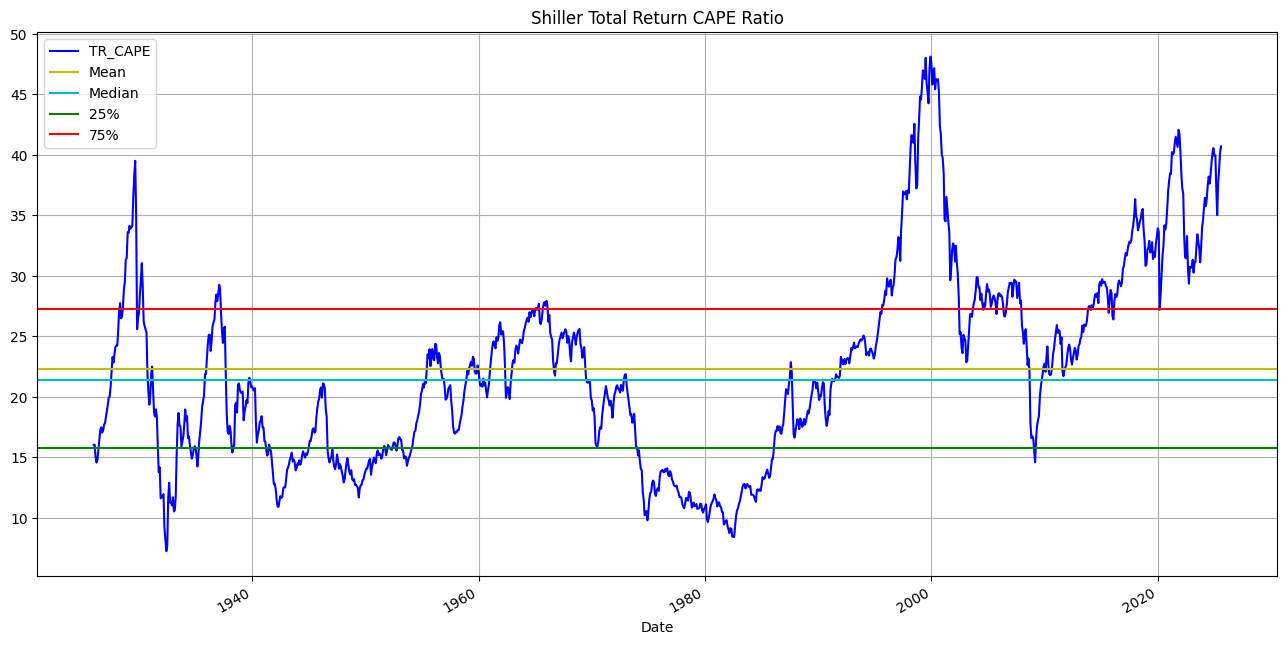

In [51]:
# Plot TR CAPE mean, median, 25% and 75% values over selected time frame
tr_cape['TR_CAPE'].plot(figsize=(16,8), title='Shiller Total Return CAPE Ratio', legend=True, c='b', grid=True)
plt.axhline(stats['mean'], c='y', label='Mean')
plt.axhline(stats['50%'], label='Median', c='c')
plt.axhline(stats['25%'], label='25%', c='g')
plt.axhline(stats['75%'], label='75%', c='r')
plt.legend()

# ECY - Excess CAPE Yield 
### ECY is calculated by the inverse of Shiller PE, which is the Shiller earnings yield, subtracted by the U.S. 10-year real Treasury bond yield. Higher ECY values indicate higher equity premium over bonds which makes stocks more attractive.
Source: 

[Equity market valuation in light of low interest rates - Ana Maria Ceh Jonatan Manfredini Ola Melander Stephan Wollert](https://www.riksbank.se/globalassets/media/rapporter/staff-memo/engelska/2021/equity-market-valuation-in-light-of-low-interest-rates.pdf)

In [52]:
stats_ecy = tr_cape['ECY(%)'].describe()
stats_ecy 

count    1197.000000
mean        0.043857
std         0.033767
min        -0.015217
25%         0.018262
50%         0.033160
75%         0.065589
max         0.143597
Name: ECY(%), dtype: float64

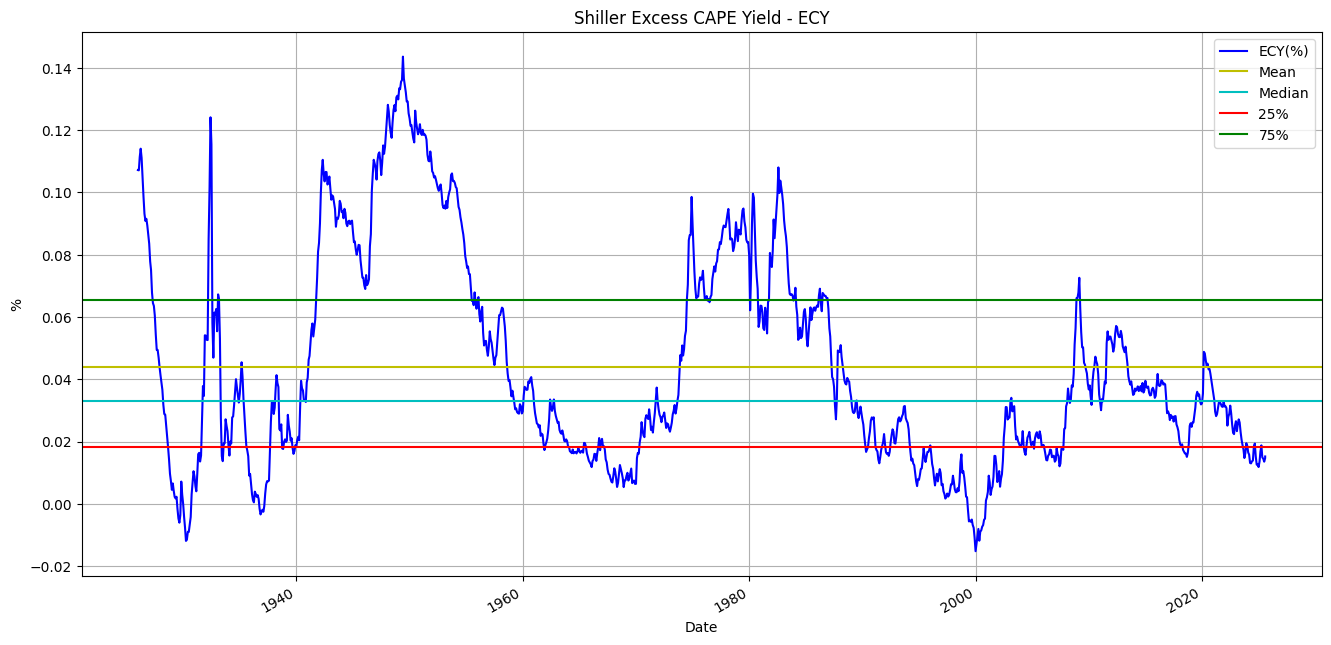

In [53]:
# Plot ECY mean, median, 25% and 75% values over selected time frame
tr_cape['ECY(%)'].plot(figsize=(16,8), title='Shiller Excess CAPE Yield - ECY', legend=True, c='b', grid=True)
plt.axhline(stats_ecy['mean'], c='y', label='Mean')
plt.axhline(stats_ecy['50%'], label='Median', c='c')
plt.axhline(stats_ecy['25%'], label='25%', c='r')
plt.axhline(stats_ecy['75%'], label='75%', c='g')
plt.ylabel('%')
plt.legend()

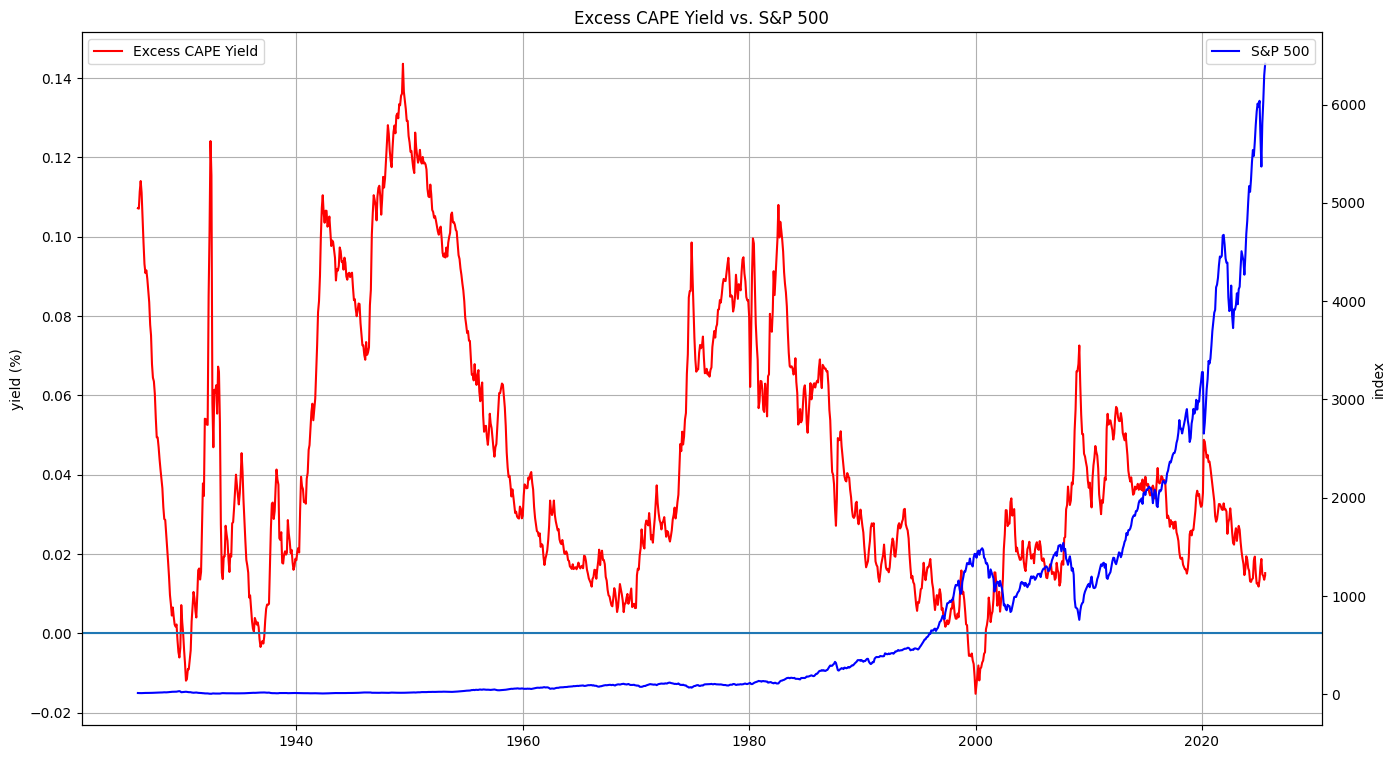

In [54]:
# Plot ECY vs S&P 500 
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(tr_cape['ECY(%)'], label ='Excess CAPE Yield', color='r')
ax.set_ylabel('yield (%)')
ax.axhline(y=0)
ax.legend(loc='upper left')
ax.grid()

ax2 = ax.twinx()
plt.plot(tr_cape['S&P500'], label='S&P 500', color='b')
ax.set_title('Excess CAPE Yield vs. S&P 500')
ax2.set_ylabel('index')
ax2.legend(loc='upper right')